<h1>Data set available <a href="https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data">here</a></h1>

Previously, we have seen the methods used to clean our data, and missing value imputation methods
This notebook Primarily focuses on EDA
### Questions to answer with this dataset
1. What is the distribution of the dataset? Is it skewed? Are there outliers?
2. How we do deal with skew?
3. Fun facts about the dataset:
   - Average PM2.5 in each month/week

4. Are we able to determine which factors will affect PM2.5?
In the next notebook, we will use the gained knowledge to create Regression Model.
<!-- 5. Are we able to estimate the PM2.5 levels with other variables in this dataset with a predictive model?
1. What are some of the use cases of this predictive model? -->


In [1]:
import pandas as pd
import numpy as np
from scripts.datacleaningutils import datacleaning
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from scipy import stats


C:\Users\maxwe\AppData\Local\Temp\ipykernel_25108\1064777033.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Exploratory Data Analysis (EDA)

We have cleaned up our data set to obtain a clean dataset now we can carry out EDA to understand our dataset better and gather some insights on this topic


Lets start with printing major statistics that are highly relevant to the problem statement

In [2]:
df = pd.read_csv("data/cleaned.csv")
df

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,2013.0,3.0,1.0,0.0,6.00,8.25,6.25,14.25,275.0,81.00,-0.550,1024.125,-20.750,0.0,5.375,NNW
1,2013.0,3.0,1.0,1.0,5.50,12.25,6.75,14.00,275.0,81.00,-0.800,1024.625,-21.125,0.0,4.100,NW
2,2013.0,3.0,1.0,2.0,4.75,5.50,7.25,15.50,275.0,71.75,-1.175,1024.850,-23.000,0.0,5.375,NNW
3,2013.0,3.0,1.0,3.0,4.25,5.00,5.25,17.00,325.0,70.50,-1.400,1025.775,-23.975,0.0,4.450,N
4,2013.0,3.0,1.0,4.0,4.00,4.75,6.25,16.00,300.0,75.50,-1.925,1026.625,-23.250,0.0,2.900,NNW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017.0,2.0,28.0,19.0,15.75,39.25,2.75,30.25,425.0,69.50,12.500,1013.500,-16.200,0.0,2.400,NW
35060,2017.0,2.0,28.0,20.0,16.75,37.25,3.25,41.00,475.0,52.50,11.600,1013.600,-15.100,0.0,0.900,WNW
35061,2017.0,2.0,28.0,21.0,18.00,40.50,4.75,49.50,575.0,41.75,10.800,1014.200,-13.300,0.0,1.100,NW
35062,2017.0,2.0,28.0,22.0,15.00,38.50,6.25,55.75,625.0,35.25,10.500,1014.400,-12.900,0.0,1.200,NNW


**Lets try to show the general trend of PM2.5 in beijing and what does the trend depict. Is there any specific reason for this trend?**

We shall start of by finding out the hourly , daily , monthly and yearly average PM2.5 and display it on a graph


In [3]:
hourly_mean = df.groupby('hour')['PM2.5'].mean()

# Daily median
daily_mean = df.groupby(['day'])['PM2.5'].mean().reset_index()

# Monthly median
monthly_mean = df.groupby(['month'])['PM2.5'].mean().reset_index()

# Yearly median
yearly_mean = df.groupby('year')['PM2.5'].mean()

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Hourly Mean PM2.5", "Daily Mean PM2.5", "Monthly Mean PM2.5", "Yearly Mean PM2.5"))

# Add traces to subplots
fig.add_trace(go.Scatter(x=hourly_mean.index, y=hourly_mean.values, mode='lines', name='Hourly Mean'), row=1, col=1)
fig.add_trace(go.Scatter(x=daily_mean.index, y=daily_mean['PM2.5'], mode='lines', name='Daily Mean'), row=1, col=2)
fig.add_trace(go.Scatter(x=monthly_mean.index, y=monthly_mean['PM2.5'], mode='lines', name='Monthly Mean'), row=2, col=1)
fig.add_trace(go.Scatter(x=yearly_mean.index, y=yearly_mean.values, mode='lines', name='Yearly Mean'), row=2, col=2)

# Update layout
fig.update_layout(height=700, width=800, title_text="Mean PM2.5 Values", showlegend=False)

# Show plot
fig.show()

### Hourly chart
- The Hourly chart shows a sharp increase after 1900, the persists until 0400 hours. This can be further generalised into saying that the average PM2.5 is higher at dark than it is in day.
- This is further supported from external sources, explaining reasons form a physics stand point:
  
<a href="https://www.nature.com/articles/s41561-023-01157-8#:~:text=With%20emptier%20streets%20and%20quieter,and%2023%3A00%20globally4">Nature.com (click)</a>
```
"With emptier streets and quieter factories, air quality at night is easily perceived as being better than during the day. However, air quality is often at its worst in the early evening hours, with PM2.5 levels peaking between 21:00 and 23:00 globally4. Unfavourable meteorological conditions are an important contributor. As the sun sets, the land surface cools, which in turn cools the overlying air. This leads to the formation of a stable atmosphere layer that suppresses vertical mixing and inhibits pollutant dispersion."
```

<a href="https://airly.org/en/why-is-air-quality-worse-at-night/#:~:text=But%20at%20night%2C%20the%20ground,pollutants%20close%20to%20the%20surface">airly.org (click)</a>
```
"During the day, the sun heats the ground, causing warm air to rise and mix with the atmosphere, which helps to disperse pollutants. But at night, the ground cools down, and this leads to a temperature inversion. This means that the air near the ground becomes colder than the air above it, trapping pollutants close to the surface."
```

### Monthly 
- We can see that the monthly mean bottoms out in month 7 (July). This is because July is monsoon season in Beijing. 
- It also peaks in mont 12 (December). Interestingly enough, our sources state that Beijing doesn't rain in winter (December), and snows a little.

<a href="https://whnt.com/weather/why-was-it-so-windy-after-storms/#:~:text=What%20happens%20is%20that%20the,sinks%20can%20create%20gusty%20winds.">whnt.com (click)</a>
```
What happens is that the air behind the rain and storms is warm, drying and sinking through the atmosphere, creating a low pressure in the “wake” of the departing rain. This descending air has high momentum and as it sinks can create gusty winds.
```

<a href="https://www.chinahighlights.com/beijing/weather.htm#:~:text=The%20rainy%20summer%20season%20is,moderate%20to%20heavy%20thundery%20showers.">chinahighlights.com (click)</a>
```
In the three months of summer (June to August), there are large amounts of rainfall in summer. Heat-driven weather systems often result in rainstorms, hail, and thunderstorms.
However, summer rain typically comes as a heavy/moderate shower during the day, and it will not affect your daily schedule too much. There is practically no rain in winter, but a little snow.
```

### Yearly 

- We can see that the yearly graph dipped significantly from 2014 to 2016 and rised from late 2016 to early 2017
- The dip was caused by the policies and measures taken by the government to mitigate air pollution
- The rise was caused by a surge in sales of vehicles leading to increase in emissions

<a href="https://aqli.epic.uchicago.edu/policy-impacts/china-national-air-quality-action-plan-2014/#:~:text=Across%20all%20urban%20areas%2C%20the,20%2C%2015%20percent%2C%20respectively.">uchicago.edu.policy (click)</a>

```
The Plan set aside $270 billion, and the Beijing city government set aside an additional $120 billion, to reduce ambient air pollution. Across all urban areas, the Plan aimed to reduce PM10 by at least 10 percent relative to 2012 levels. The most heavily-polluted areas in the country were given specific targets

```

<a href="https://www.business-standard.com/article/pti-stories/china-has-310-mln-registered-vehicles-385-mln-drivers-in-2017-118011501092_1.html">business-standard.com(click)</a>

```
 30.54 million new drivers were registered in 2017 across China, which is the world's largest automobile market, according to the country's Ministry of Public Security. "In 2017, the number of newly-registered vehicles and drivers reached 33.52 million and 30.54 million respectively," according to the ministry's traffic management bureau. 

```

**From this we can see that air quality in beijing is deteriorating at a steady pace despite the governments policies. But what are possible factors that lead to this trend**

**Lets find out.**


# Lets See the relations between temperature and PM2.5


**My hypothesis is that a rise in temperature would lead to a fall in PM2.5 Values.**

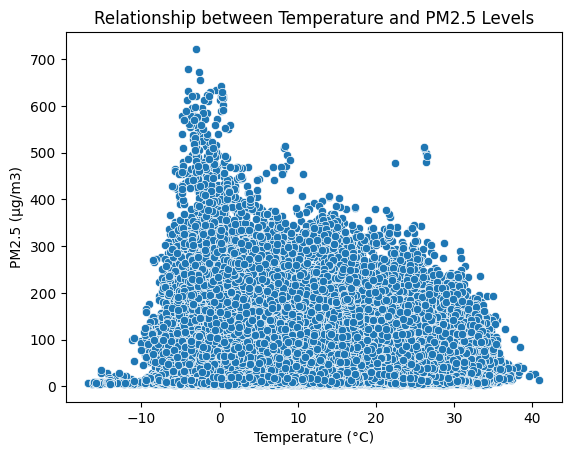

The Pearson correlation coefficient between temperature and PM2.5 is: -0.15


In [4]:
# Assuming 'df' is your DataFrame and it includes 'Temperature' and 'PM2.5' columns
sns.scatterplot(x='TEMP', y='PM2.5', data=df)
plt.title('Relationship between Temperature and PM2.5 Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('PM2.5 (µg/m3)')
plt.show()

correlation = df['TEMP'].corr(df['PM2.5'])
print(f"The Pearson correlation coefficient between temperature and PM2.5 is: {correlation:.2f}")


My hypothesis was indeed right. There is a negative correlation between temperature and PM2.5. There is no stromg relation which is seen by the negative correlation coefficient of -0.15 that suggests a  moderate inverse relationship.

Some of the reasons for this can include seasoal changes or weather patterns. Winter weather can lead to stagnant air masses, trapping pollutants closer to the ground and resulting in higher concentrations of PM2.5. Temperature inversions, where pollutants become trapped by warmer air, hence increasing PM2.5.



<a href="https://www.sciencedirect.com/science/article/abs/pii/S1352231023001231">sciencedirect (click)</a>


**Lets analyse in a different angle. Changes in weather patterns such as wind or rain can also affect PM2.5. I believe Windspeed and rain will be positively correlated to PM2.5.**

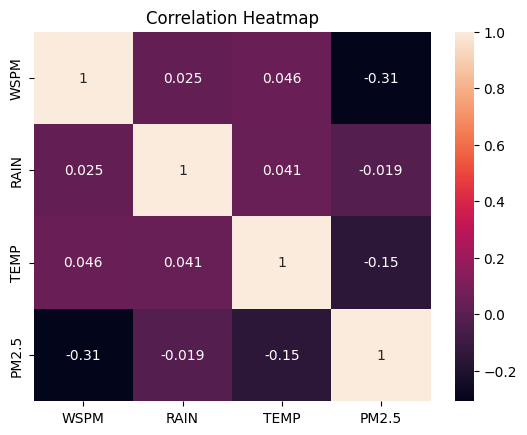

In [5]:

correlation_matrix = df[['WSPM', 'RAIN', 'TEMP', 'PM2.5']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

My hypothosis has been proven wrong. From this dataset we can understand that Rain and WPSM is not highly correlated hence it does not have much impact on the changes in PM2.5.  Using these data to estimate or predict PM2.5 would lead to inaccurate PM2.5 values hence it is a weak factor of PM2.5 and there could be other significant factors that affect the concentration of PM2.5.

**Lets now look at the Proportion of PM 2.5 Values and its range**

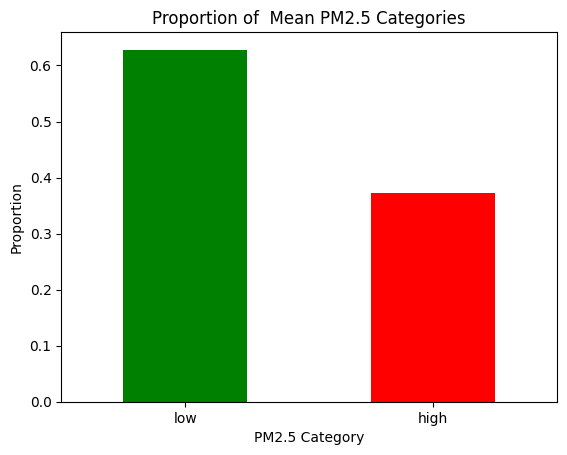

In [6]:
pm25_threshold = df['PM2.5'].mean()

# Categorize the data
df['PM2.5 '] = df['PM2.5'].apply(lambda x: 'high' if x > pm25_threshold else 'low')

# Group and calculate proportions
category_counts = df['PM2.5 '].value_counts(normalize=True)

# Plotting
category_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Proportion of  Mean PM2.5 Categories')
plt.xlabel('PM2.5 Category')
plt.ylabel('Proportion')
plt.xticks(rotation=0)  # Rotates category labels horizontally
plt.show()

We have categorised the PM 2.5 values into 2 ranges of low and high. The proportion of low is 0.6 while the proportion of high is 0.4. Low proportion of PM2.5 data is between moderate to unhealthy for certain groups while high denotes from unhealthy to hazardous. 

## Lets calculate the Median Mode and IQR

In [7]:
df_numeric = df.select_dtypes(include=[np.number])

# Calculate median for each numeric column
median_values = df_numeric.median()

# Calculate mode for each numeric column
mode_values = df_numeric.mode().iloc[0]  # This returns the first mode in case there are multiple modes

# Calculate IQR for each numeric column
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Displaying the results
print("Median Values:")
print(median_values)
print("\nMode Values:")
print(mode_values)
print("\nInterquartile Range (IQR) Values:")
print(IQR)

Median Values:
year     2015.00
month       7.00
day        16.00
hour       11.50
PM2.5      60.00
PM10       87.50
SO2         8.75
NO2        49.75
CO        950.00
O3         42.50
TEMP       14.60
PRES     1012.10
DEWP        3.20
RAIN        0.00
WSPM        1.50
dtype: float64

Mode Values:
year     2016.00
month       1.00
day         1.00
hour        0.00
PM2.5       9.25
PM10       19.25
SO2         2.00
NO2        23.00
CO        300.00
O3          2.00
TEMP        3.00
PRES     1025.00
DEWP       17.60
RAIN        0.00
WSPM        1.10
Name: 0, dtype: float64

Interquartile Range (IQR) Values:
year        2.000000
month       6.000000
day        15.000000
hour       11.500000
PM2.5      92.250000
PM10      106.250000
SO2        18.250000
NO2        45.509575
CO       1075.000000
O3         70.750000
TEMP       20.256250
PRES       16.900000
DEWP       23.775000
RAIN        0.000000
WSPM        1.325000
dtype: float64


The median is the middle value of the dataset and divides dataset into 2 parts. It is not affected by outliers hence a better approximation compared to mean. Furthermore it is more useful when the data has numerous outliers or skewed.

Mode : most frequent values of PM2.5 in the dataset.

**Now that we have the median mode and IQR , lets plot a box plot to display these values clearly so that we can visualise the data effectively.**

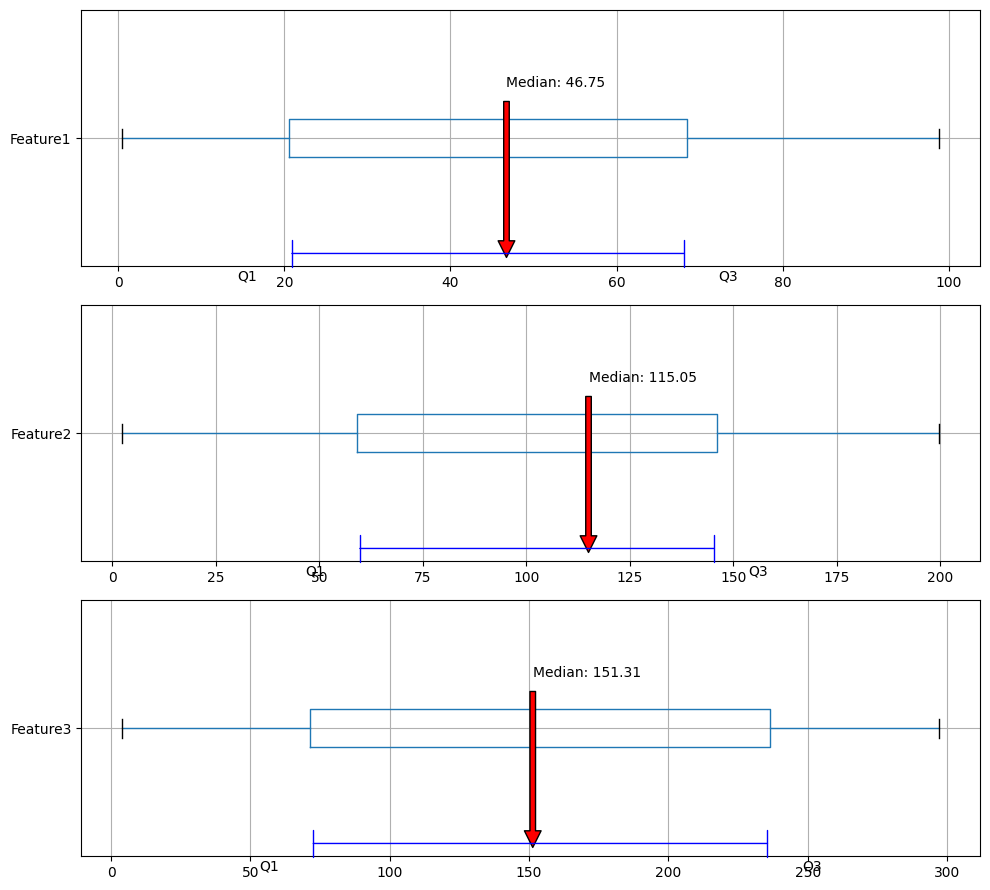

In [8]:

np.random.seed(0)
data = {
    'Feature1': np.random.rand(100) * 100,
    'Feature2': np.random.rand(100) * 200,
    'Feature3': np.random.rand(100) * 300,
}
df = pd.DataFrame(data)

# Select only numeric data types
df_numeric = df.select_dtypes(include=[np.number])

# Calculate median, mode, and IQR for each numeric column
median_values = df_numeric.median()
mode_values = df_numeric.mode().iloc[0]  # First mode in case there are multiple modes
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Adjusting the figure size to make it smaller
fig, axes = plt.subplots(nrows=len(df_numeric.columns), figsize=(10, 3 * len(df_numeric.columns)))  # Adjusted multiplier here

# Check if there's only one column to avoid indexing error
if len(df_numeric.columns) == 1:
    axes = [axes]  # Make it iterable

# Plotting boxplots
for ax, col in zip(axes, df_numeric.columns):
    # Boxplot for each column
    df_numeric.boxplot(column=col, ax=ax, vert=False)
    
    # Annotations for median
    ax.annotate(f'Median: {median_values[col]:.2f}', xy=(median_values[col], 0.5), xytext=(median_values[col], 1.2),
                arrowprops=dict(facecolor='red', shrink=0.05))
    
    # Annotations for IQR
    ax.annotate('Q1', xy=(Q1[col], 0.5), textcoords='offset points', xytext=(-30, -10), ha='center')
    ax.annotate('Q3', xy=(Q3[col], 0.5), textcoords='offset points', xytext=(30, -10), ha='center')
    ax.annotate('', xy=(Q1[col], 0.55), xytext=(Q3[col], 0.55), arrowprops=dict(arrowstyle='|-|', color='blue'))

# Tight layout to ensure no overlap
plt.tight_layout()
plt.show()


----------------

# Lets plot a pie chart to see which is the highest concentration of particles in the air

In [9]:
df = pd.read_csv("data/cleaned.csv")
df

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,wd
0,2013.0,3.0,1.0,0.0,6.00,8.25,6.25,14.25,275.0,81.00,-0.550,1024.125,-20.750,0.0,5.375,NNW
1,2013.0,3.0,1.0,1.0,5.50,12.25,6.75,14.00,275.0,81.00,-0.800,1024.625,-21.125,0.0,4.100,NW
2,2013.0,3.0,1.0,2.0,4.75,5.50,7.25,15.50,275.0,71.75,-1.175,1024.850,-23.000,0.0,5.375,NNW
3,2013.0,3.0,1.0,3.0,4.25,5.00,5.25,17.00,325.0,70.50,-1.400,1025.775,-23.975,0.0,4.450,N
4,2013.0,3.0,1.0,4.0,4.00,4.75,6.25,16.00,300.0,75.50,-1.925,1026.625,-23.250,0.0,2.900,NNW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017.0,2.0,28.0,19.0,15.75,39.25,2.75,30.25,425.0,69.50,12.500,1013.500,-16.200,0.0,2.400,NW
35060,2017.0,2.0,28.0,20.0,16.75,37.25,3.25,41.00,475.0,52.50,11.600,1013.600,-15.100,0.0,0.900,WNW
35061,2017.0,2.0,28.0,21.0,18.00,40.50,4.75,49.50,575.0,41.75,10.800,1014.200,-13.300,0.0,1.100,NW
35062,2017.0,2.0,28.0,22.0,15.00,38.50,6.25,55.75,625.0,35.25,10.500,1014.400,-12.900,0.0,1.200,NNW


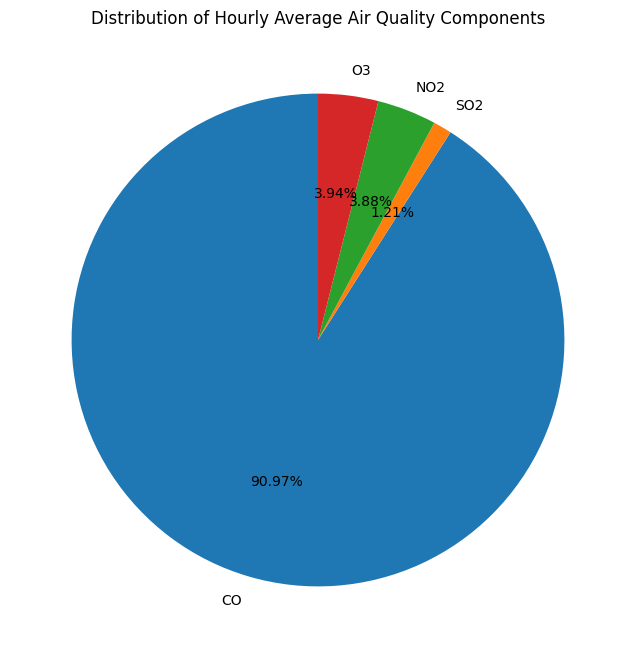

In [10]:
components = ['CO', 'SO2', 'NO2', 'O3']
hourly_air_quality_filtered = df[components]

# Calculate hourly average air quality for the selected components
hourly_average = hourly_air_quality_filtered.mean()

# Plot pie chart
plt.figure(figsize=(8, 8))  # Set the figure size
hourly_average.plot.pie(labels=hourly_average.index, autopct="%.2f%%", startangle=90)
plt.ylabel('')  # Remove y-label
plt.title('Distribution of Hourly Average Air Quality Components')  # Add a title
plt.show()



As we can see from the pie chart CO has the highest concentration while SO2 has the lowest concentration. These show the pollutants in the air and what PM2.5 is composed of.


<a href="https://www.sciencedirect.com/science/article/abs/pii/S1001074220304678
">O3 Sciencedirect</a>

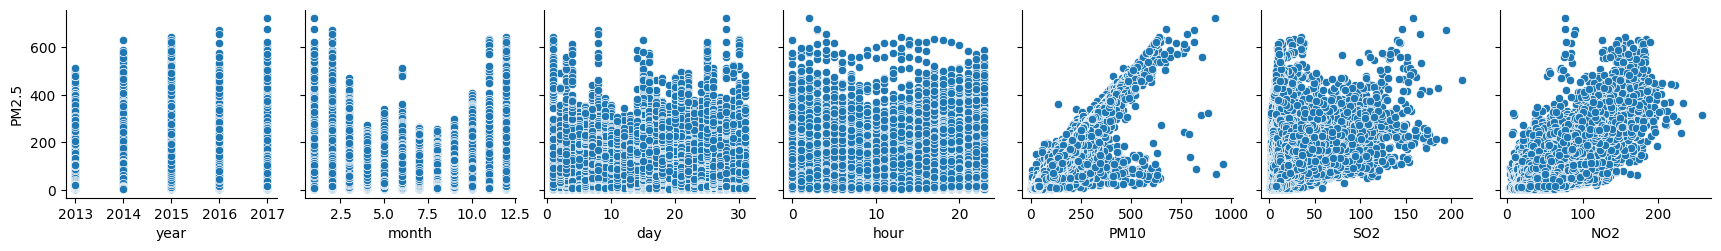

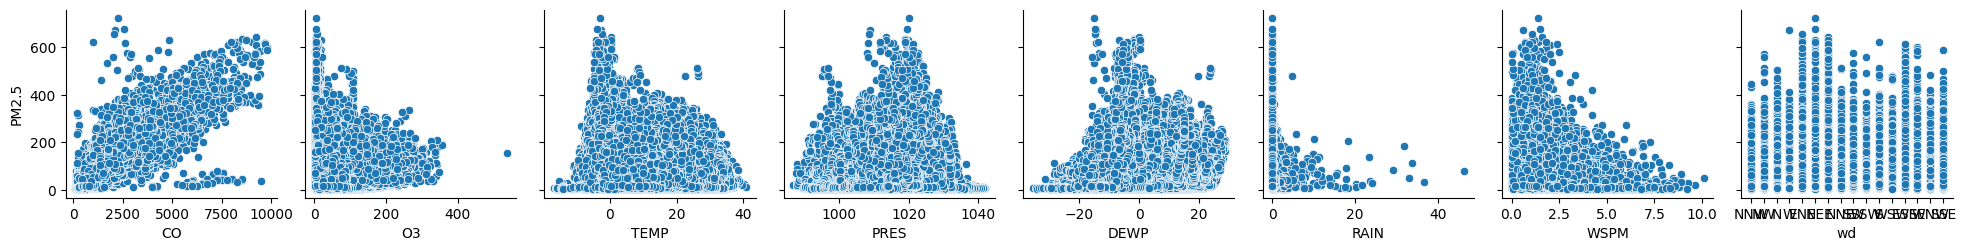

In [11]:
def scatter_matrix_plot_seaborn(dataframe, target_column):
    # Filter out the target column
    columns_to_plot = [col for col in dataframe.columns if col != target_column]
    num_cols = len(columns_to_plot) // 2
    sns.pairplot(dataframe, y_vars=[target_column], x_vars=columns_to_plot[:num_cols])
    sns.pairplot(dataframe, y_vars=[target_column], x_vars=columns_to_plot[num_cols:])
    
    # Show the plot
    plt.show()

scatter_matrix_plot_seaborn(df, 'PM2.5')

### From the scatterplots, we can observe (empirically) that PM10, SO2, NO2, CO have strong correlations with PM2.5
### Since empirical observations are not enough, let's plot a heatmap to get the ACTUAL correlation values

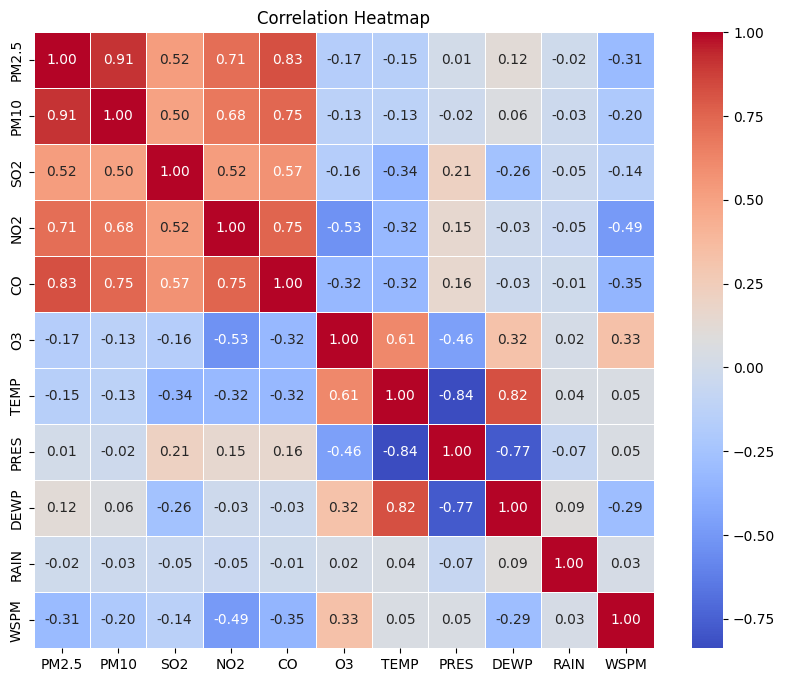

In [12]:
numeric_columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
numeric_df = df[numeric_columns]

corr_matrix = df[numeric_columns].corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

### We can confirm our empirical inference that PM10, SO2, NO2, and CO have strong positive correlations.
### However, we can see that O3, DEWP, WSPM have *moderate* correlations
### PRES, RAIN, TEMP have *weak to **VERY** weak* correlations
### This finding compliments our research done in existing Air Quality Research articles.

<a href="https://www.waikatoregion.govt.nz/environment/air/weather-and-air/#:~:text=or%20no%20wind.-,Wind%20speed,in%20dry%20windy%20rural%20areas.">Windspeed Article here</a>
```
Wind speed 
"Wind carries air contaminants away from their source, causing them to disperse. In general, the higher the wind speed, the more contaminants are dispersed and the lower their concentration. However, high wind can also generate dust – a problem in dry windy rural areas."
```
<a href="https://www.sciencedirect.com/science/article/abs/pii/S0048969723010501#:~:text=Through%20the%20combined%20effect%20of,autumn%20and%20winter%20in%20YRD.">O3 Article here</a>
```
"Through the combined effect of two chemical processes, PM2.5 can lead to a decrease in O3 concentration of −3.3 ppb (−7.6 %), −2.2 ppb (−4.0 %), −2.9 ppb (−6.3 %), and − 5.9 ppb (−18.7 %), in spring, summer, autumn and winter in YRD. Therefore, if the PM2.5 concentration decreases, the weakening effect of PM2.5 on the ozone concentration will be reduced, resulting in the aggravation of ozone pollution. "
```


In [13]:
import plotly.graph_objects as go

# Define thresholds and colors
thresholds = {
    'Good': (0, 12, '#0C2C84'),  # Dark blue
    'Moderate': (12.1, 35.4, '#1D91C0'),  # Blue
    'Unhealthy for Sensitive Groups': (35.5, 55.4, '#FECC5C'),  # Yellow
    'Unhealthy': (55.5, 150.4, '#FD8D3C'),  # Orange
    'Very Unhealthy': (150.5, 250.4, '#F03B20'),  # Red
    'Hazardous': (250.5, float('inf'), '#BD0026')  # Maroon
}

# Create a color column based on PM2.5 value
def get_color(pm_value):
    for key, (min_val, max_val, color) in thresholds.items():
        if min_val <= pm_value <= max_val:
            return color
    return '#FFFFFF'  # Default color if something goes wrong

monthly_mean['Color'] = monthly_mean['PM2.5'].apply(get_color)

# Plotting
fig = go.Figure()

for key, (min_val, max_val, color) in thresholds.items():
    # Filter data for each category and plot
    mask = (monthly_mean['PM2.5'] >= min_val) & (monthly_mean['PM2.5'] <= max_val)
    fig.add_trace(go.Scatter(x=monthly_mean.index[mask], 
                             y=monthly_mean['PM2.5'][mask],
                             marker=dict(color=color),
                             name=key))
    fig.add_shape(type="line",
                  x0=monthly_mean.index.min(),
                  y0=min_val,
                  x1=monthly_mean.index.max(),
                  y1=min_val,
                  line=dict(color=color, width=1, dash='dash'),
                  name=key + " Lower Bound")

fig.update_layout(title='Monthly Average PM2.5 Levels Over Time by Health Category (2013-2017)',
                  xaxis_title='Date',
                  yaxis_title='PM2.5 Concentration (µg/m³)',
                  legend_title='Category')
fig.show()


We can see that the monthly average on the PM2.5 levels is within unhealthy range

Let's check how frequent unhealthy ranges occur

c:\Coding\SC1015DSAI\venv\Lib\site-packages\matplotlib\axes\_axes.py:6895: RuntimeWarning:

invalid value encountered in multiply



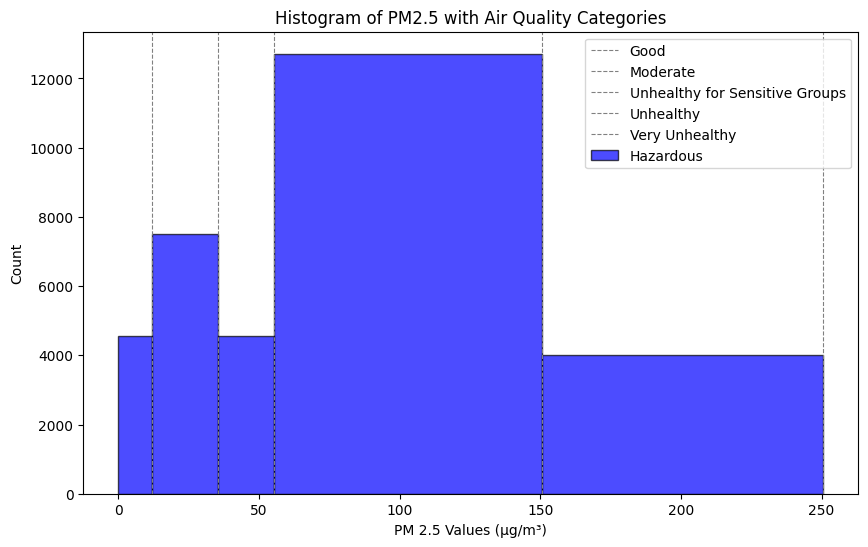

In [14]:
# # Define bin edges
bin_edges = [0, 12.1, 35.5, 55.5, 150.5, 250.5, float('inf')]

# Define bin labels
bin_labels = ['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous']
colors = ['Blue']

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['PM2.5'], bins=bin_edges, edgecolor='black', alpha=0.7,color=colors)

# Add labels and title
plt.xlabel('PM 2.5 Values (µg/m³)')
plt.ylabel('Count')
plt.title('Histogram of PM2.5 with Air Quality Categories')

# Add vertical lines for bin edges
for edge in bin_edges[1:-1]:
    plt.axvline(x=edge, color='gray', linestyle='--', linewidth=0.8)

# Add legend
plt.legend(['Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous'], loc='upper right')

plt.show()


The US EPA provides a standard called the Air Quality Index (AQI) which categorizes different PM2.5 concentration levels into health-related groups. For this example, we'll use a simplified version of these thresholds:

Good: 0-12 µg/m³

Moderate: 12.1-35.4 µg/m³

Unhealthy for Sensitive Groups: 35.5-55.4 µg/m³

Unhealthy: 55.5-150.4 µg/m³

Very Unhealthy: 150.5-250.4 µg/m³

Hazardous: 250.5 µg/m³ and above

https://aqicn.org/city/beijing/

<a href="https://aqicn.org/city/beijing/">O3 aqicn.org</a>

# Let us plot a box plot to show windspeed and its relation to PM 2.5 #

In [15]:
def group_wspm_median(wspm, median):
    if wspm <= median:
        return 'low'
    else:
        return 'high'

median_wspm = df['WSPM'].median()
df['grouped_wspm'] = df['WSPM'].apply(lambda x: group_wspm_median(x, median_wspm))



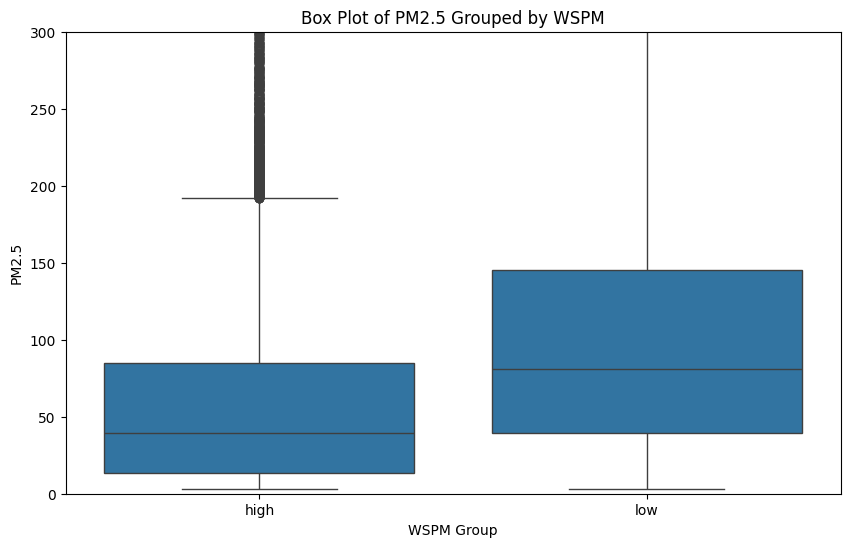

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='grouped_wspm', y='PM2.5', data=df)
plt.title('Box Plot of PM2.5 Grouped by WSPM')
plt.xlabel('WSPM Group')
plt.ylabel('PM2.5')
plt.ylim(0, 300)  # Set y-axis limits
plt.show()

### The boxplot shown indicates that the correlation is not a fluke. Higher windspeeds tend to reduce PM2.5 levels


# But could it be possible for the data to be skewed lets test it out

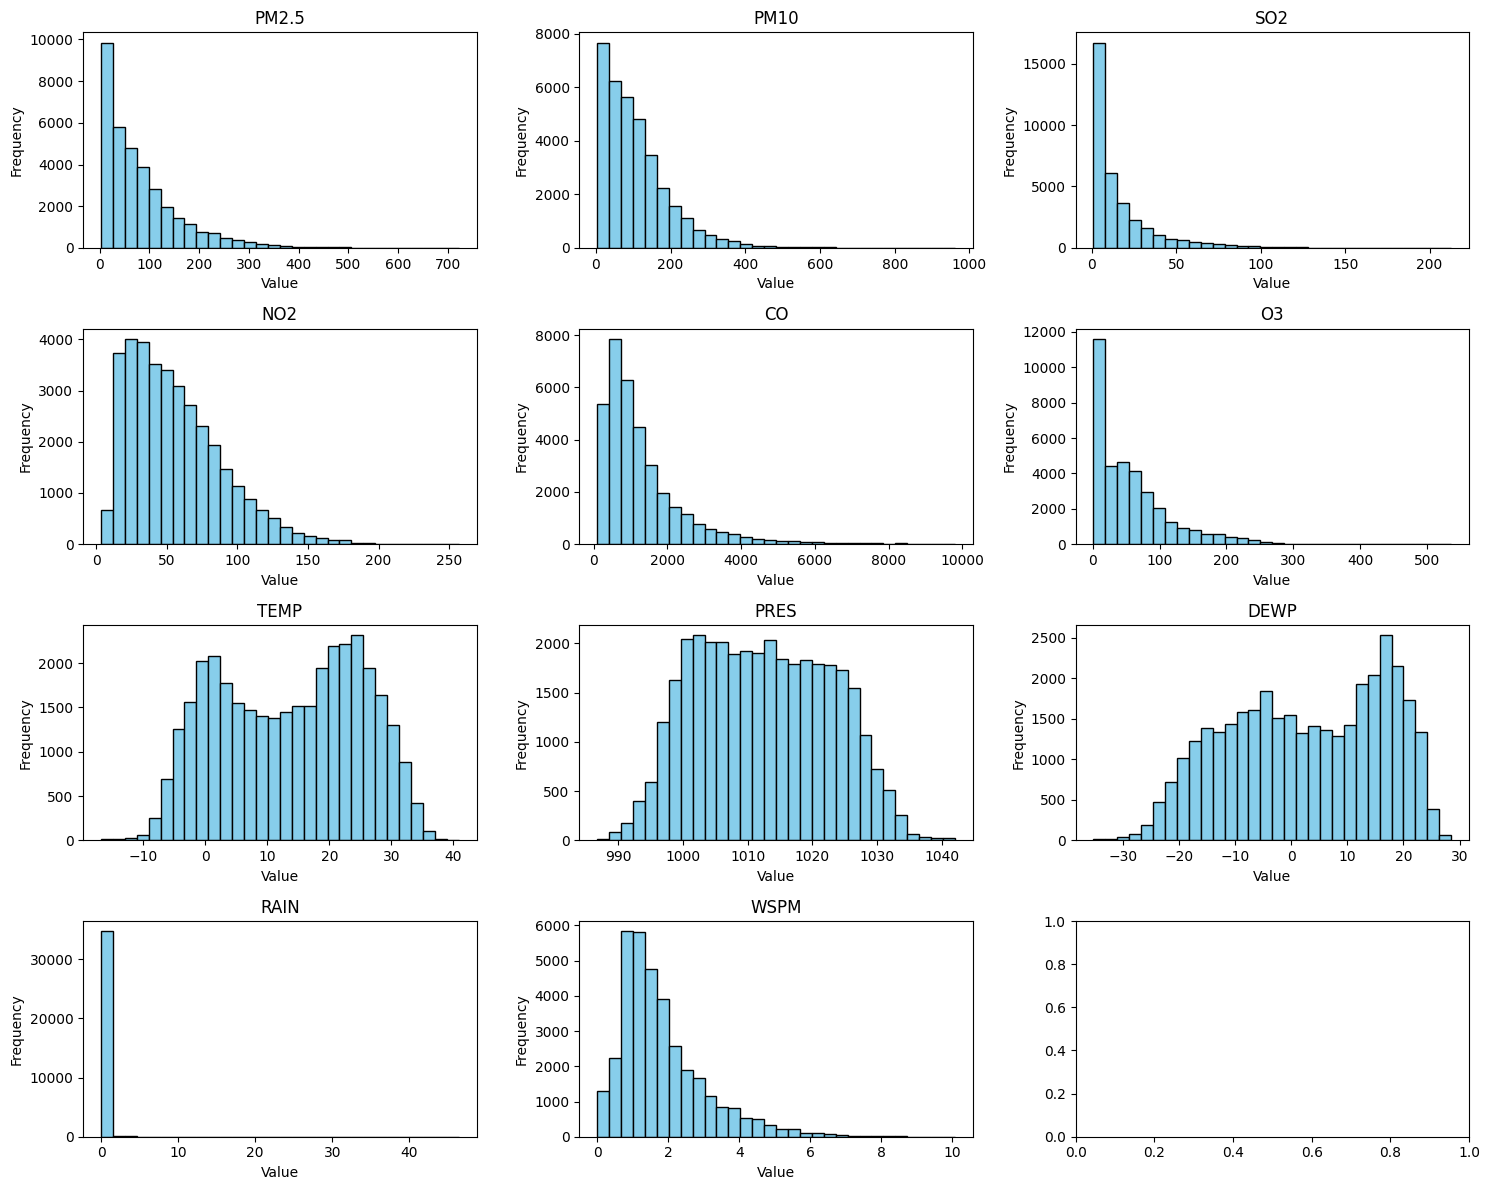

In [17]:
columns_to_plot = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Plot histograms for each column
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
for i, column in enumerate(columns_to_plot):
    ax = axes.flatten()[i]
    ax.hist(df[column], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    

# Adjust layout
plt.tight_layout()
plt.show()


As i suspected this graph is skewed because mean is greater than the median which indicates positively skewed data. Lets figure out how to eradicate the skew such that the data is much more accurate.

### Before wrapping up this Notebook, we will take note our our top predictors
#### Categorical
- month
- hour
#### Numeric
- PM10
- SO2
- NO2
- CO
- O3
- DEWP
- projection